In [1]:
import yfinance as yf
import requests
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime as dt
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

In [2]:
name = ['SPGI','VZ','TSLA','PG','DIS','SYY','AAPL','XOM','BRK-B','UNH']
df1 = pd.DataFrame()
df2 = pd.DataFrame()
df3 = pd.DataFrame()
df4 = pd.DataFrame()
df5 = pd.DataFrame()
df6 = pd.DataFrame()
df7 = pd.DataFrame()
df8 = pd.DataFrame()
df9 = pd.DataFrame()
df10 = pd.DataFrame()
d2 = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [3]:
for i in range(10):
    d2[i] = yf.download(name[i],start = '2019-01-01')


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[1:]

In [5]:
for i in range(10):
    d2[i]['rsi_14'] = get_rsi(d2[i]['Close'], 14)
    d2[i] = d2[i].dropna()

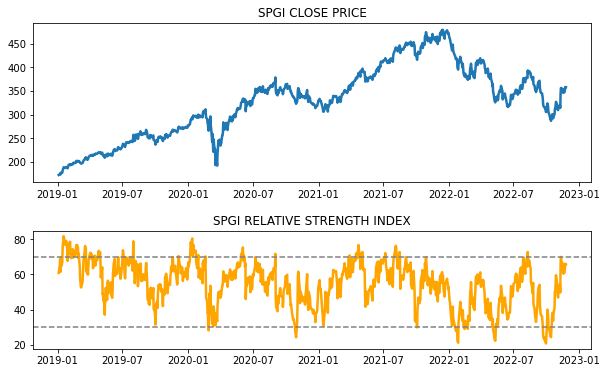

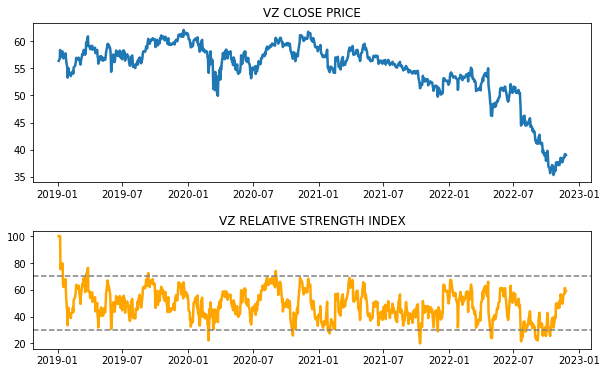

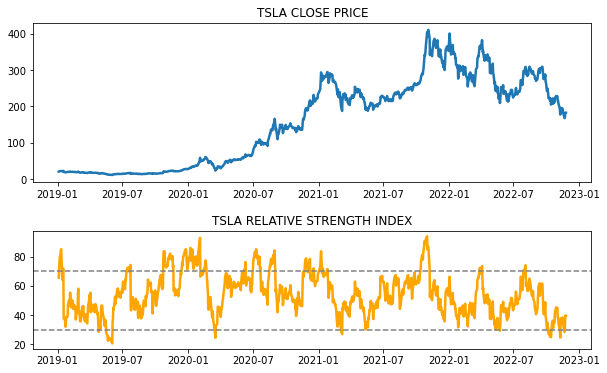

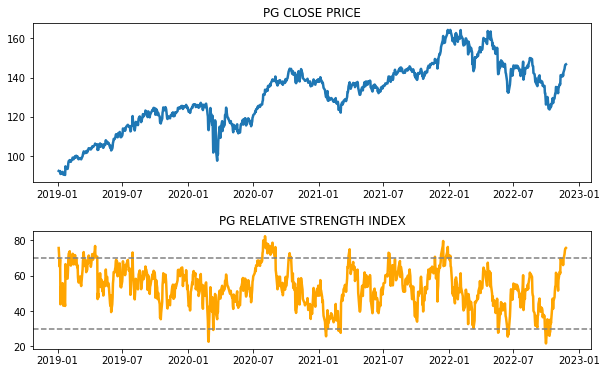

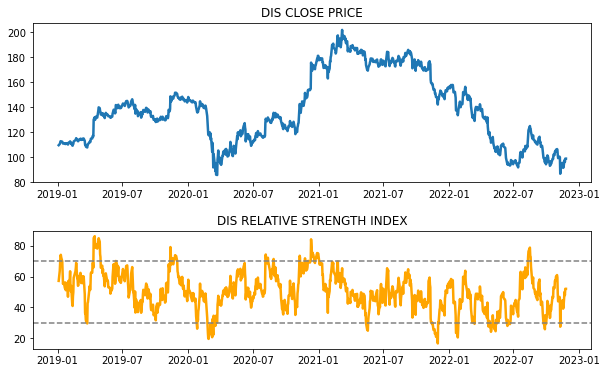

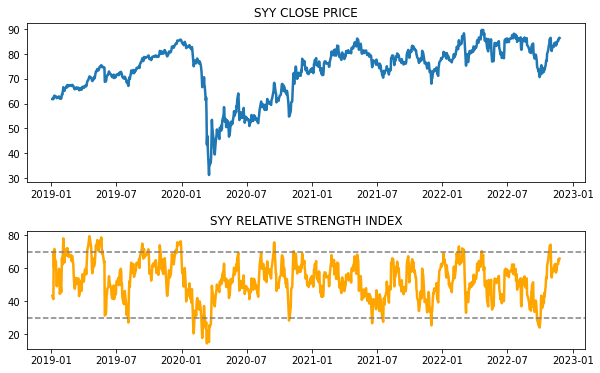

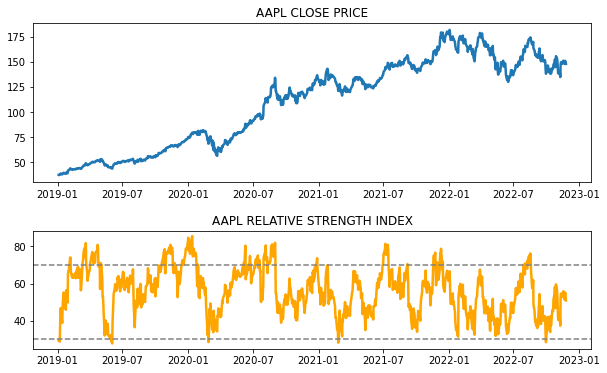

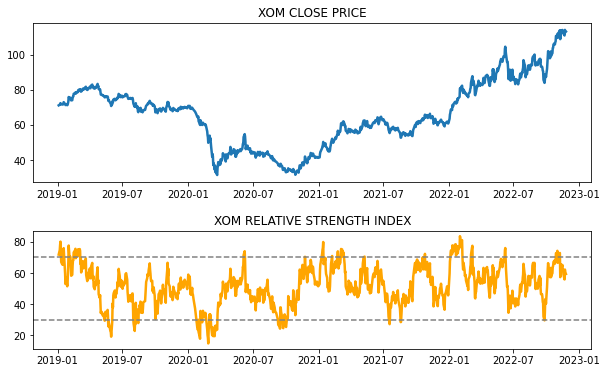

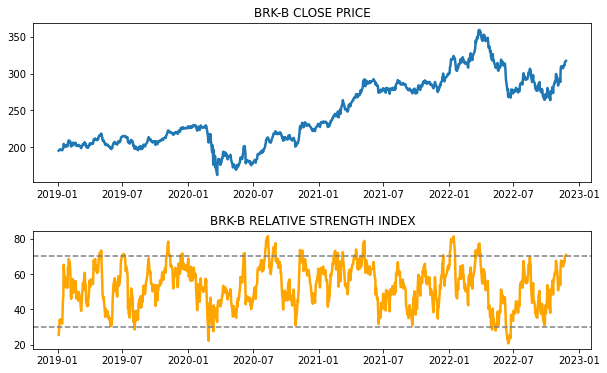

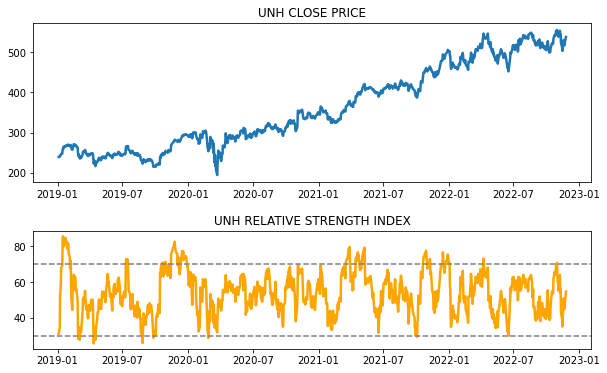

In [6]:
for i in range(10):
    plt.figure(figsize=(10,6))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 4, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 4, colspan = 1)
    ax1.plot(d2[i]['Close'], linewidth = 2.5)
    ax1.set_title(name[i]+' CLOSE PRICE')
    ax2.plot(d2[i]['rsi_14'], color = 'orange', linewidth = 2.5)
    ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.set_title(name[i] + ' RELATIVE STRENGTH INDEX')
    plt.show()

In [7]:
def implement_rsi_strategy(prices, rsi):    
    buy_price = []
    sell_price = []
    rsi_signal = []
    signal = 0

    for i in range(len(rsi)):
        if rsi[i-1] > 30 and rsi[i] < 30:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        elif rsi[i-1] < 70 and rsi[i] > 70:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                rsi_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                rsi_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            rsi_signal.append(0)
            
    return buy_price, sell_price, rsi_signal

In [8]:
buy_price = [0] * 10
sell_price = [0] * 10
rsi_signal = [0] * 10
for i in range(10):
    buy_price[i], sell_price[i], rsi_signal[i] = implement_rsi_strategy(d2[i]['Close'], d2[i]['rsi_14'])

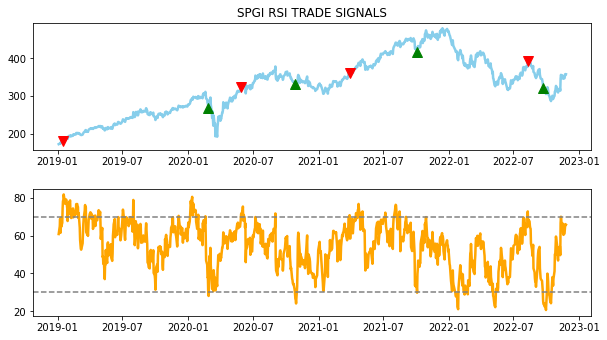

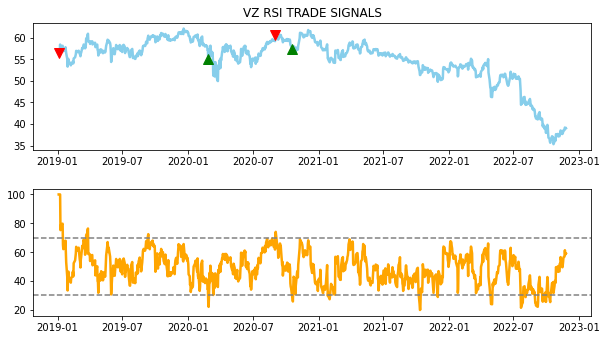

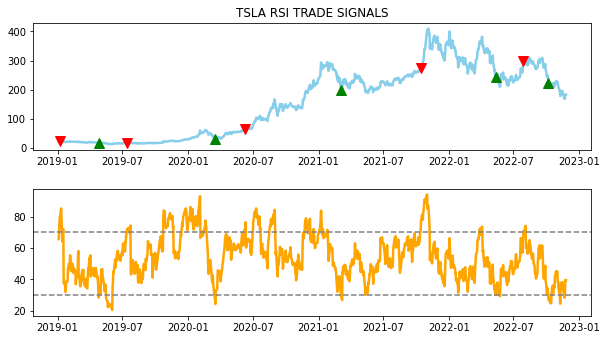

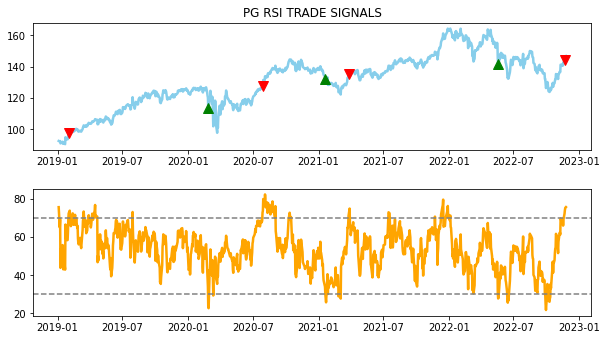

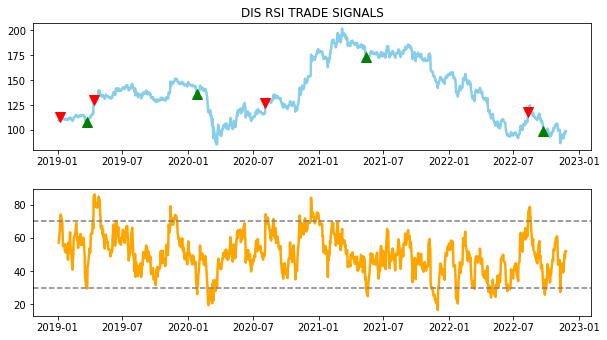

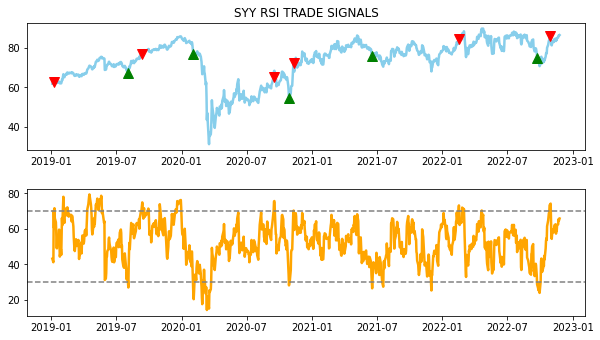

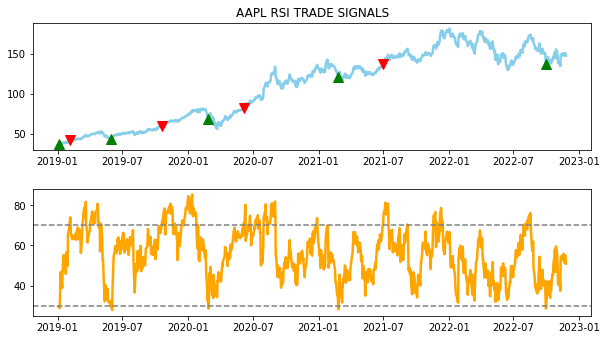

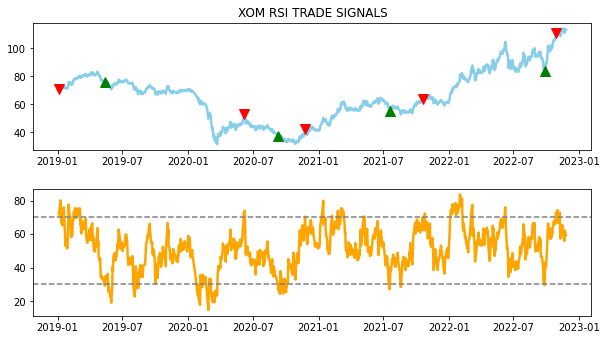

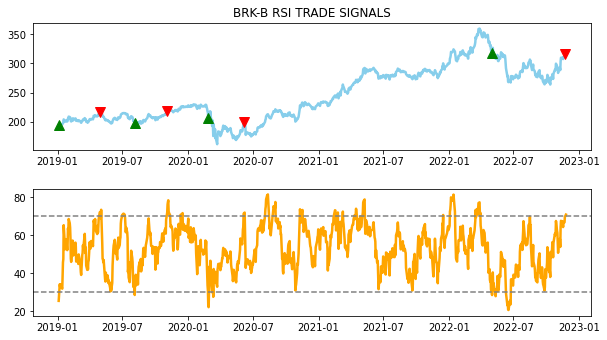

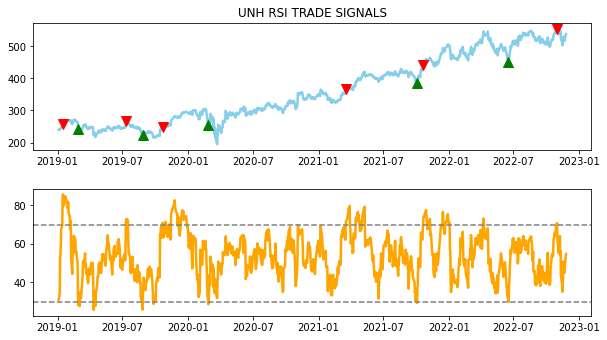

In [9]:
for i in range(10):
    plt.figure(figsize=(10,6))
    ax1 = plt.subplot2grid((10,1), (0,0), rowspan = 4, colspan = 1)
    ax2 = plt.subplot2grid((10,1), (5,0), rowspan = 4, colspan = 1)
    ax1.plot(d2[i]['Close'], linewidth = 2.5, color = 'skyblue', label = 'IBM')
    ax1.plot(d2[i].index, buy_price[i], marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
    ax1.plot(d2[i].index, sell_price[i], marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
    ax1.set_title(name[i]+ ' RSI TRADE SIGNALS')
    ax2.plot(d2[i]['rsi_14'], color = 'orange', linewidth = 2.5)
    ax2.axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
    ax2.axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
    plt.show()

In [10]:
strategy = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]

In [11]:
for j in range(10):
    position = []
    for i in range(len(rsi_signal[j])):
        if rsi_signal[j][i] > 1:
            position.append(0)
        else:
            position.append(1)
        
    for i in range(len(d2[j]['Close'])):
        if rsi_signal[j][i] == 1:
            position[i] = 1
        elif rsi_signal[j][i] == -1:
            position[i] = 0
        else:
            position[i] = position[i-1]
        
    rsi = d2[j]['rsi_14']
    close_price = d2[j]['Close']
    rsi_signal[j] = pd.DataFrame(rsi_signal[j]).rename(columns = {0:'rsi_signal'}).set_index(d2[j].index)
    position = pd.DataFrame(position).rename(columns = {0:'rsi_position'}).set_index(d2[j].index)

    frames = [close_price, rsi, rsi_signal[j], position]
    strategy[j] = pd.concat(frames, join = 'inner', axis = 1)  

In [12]:
strategy[0].tail()

,Close,rsi_14,rsi_signal,rsi_position
Date,,,,
2022-11-18,345.869995,60.355248,0,1
2022-11-21,347.420013,61.090164,0,1
2022-11-22,352.250000,63.368907,0,1
2022-11-23,358.269989,66.038570,0,1
2022-11-25,357.910004,65.730078,0,1


In [13]:
# do not need to minus-1 for cum
def calcReturns(df):
    df['returns'] = df['Close'] / df['Close'].shift(1)
    df['log_returns'] = np.log(df['returns'])
    df['strat_returns'] = df['rsi_position'].shift(1) * df['returns']
    df['strat_log_returns'] = df['rsi_position'].shift(1) * df['log_returns']
    df['cum_returns'] = np.exp(df['log_returns'].cumsum()) 
    df['strat_cum_returns'] = np.exp(df['strat_log_returns'].cumsum()) 
  

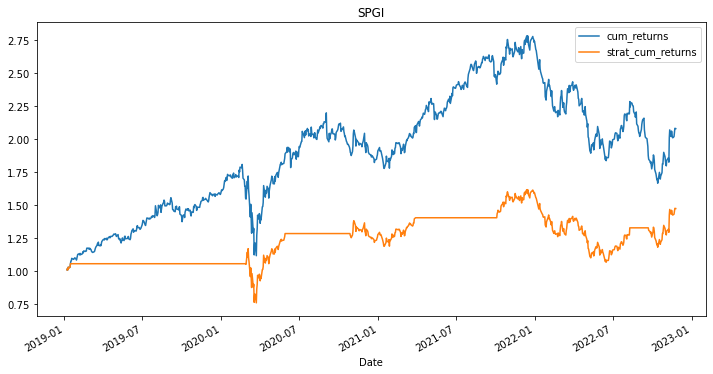

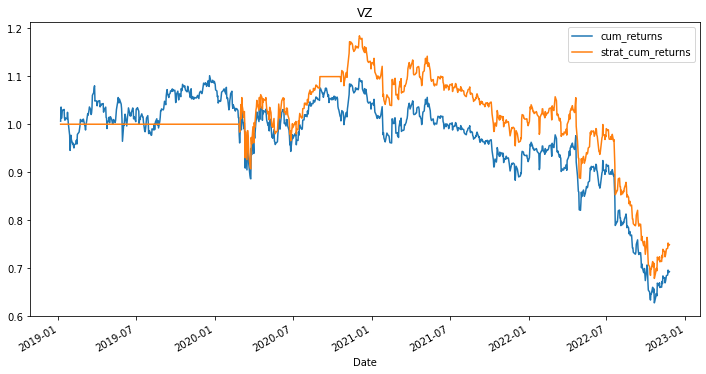

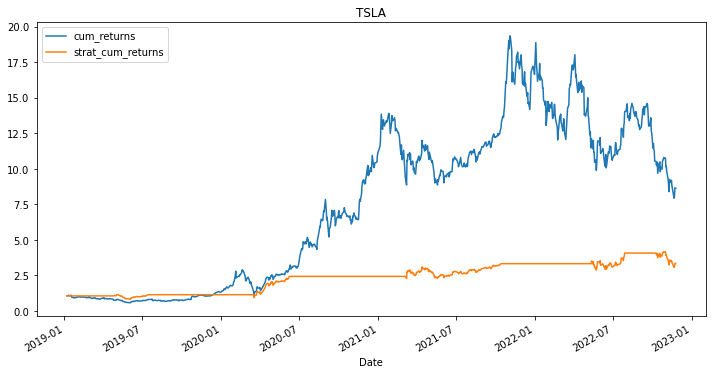

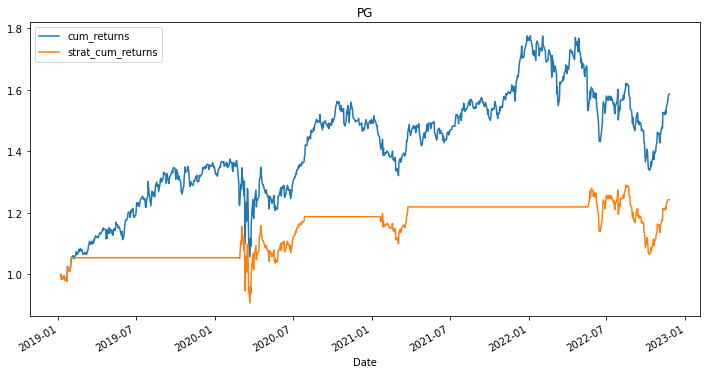

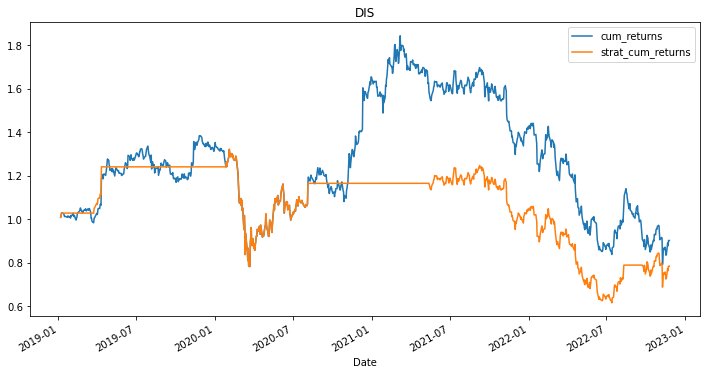

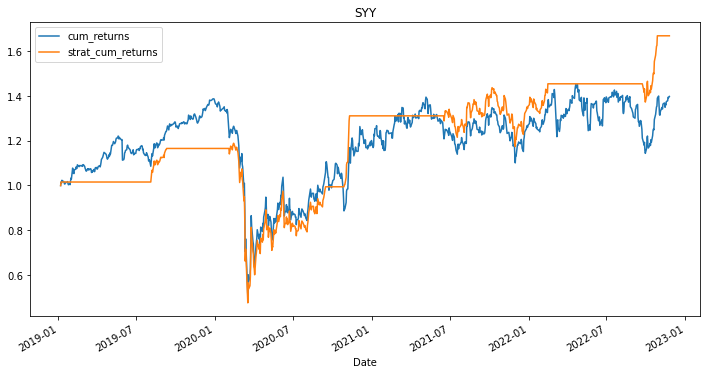

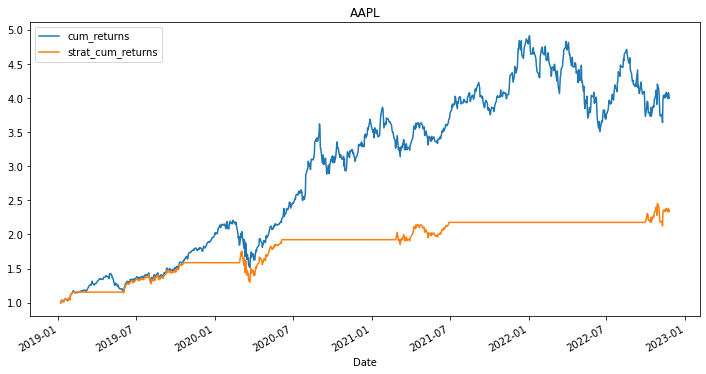

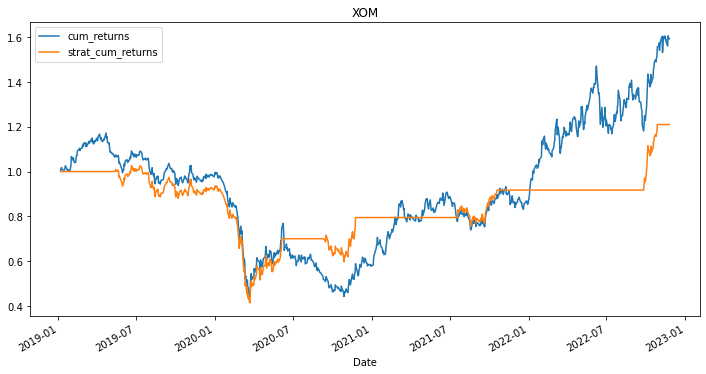

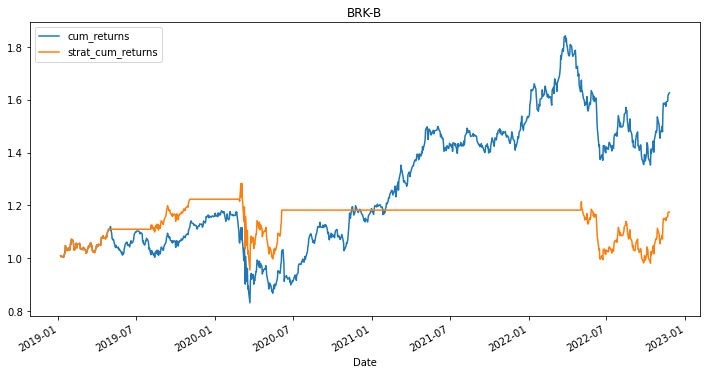

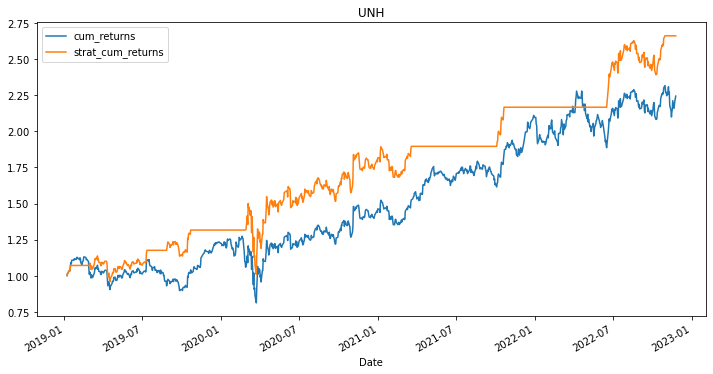

In [14]:

for i in range(10):
    calcReturns(strategy[i])
    (strategy[i][['cum_returns','strat_cum_returns']]).plot(figsize=(12,6))
    plt.title(label =name[i])
    plt.show()
    

## Sharpe Ratio

In [ ]:
# equal weights
# assign by capitalization

In [15]:
for i in range(10):
    strategy[i] = strategy[i][1:]

In [16]:
# assign weights for stocks in portfolio
weights = [0.1, 0.1, 0.1, 0.1, 0.1 ,0.1, 0.1, 0.1, 0.1, 0.1]
for stock_df, allocation in zip(strategy,weights):
     stock_df['Allocation'] = stock_df['strat_cum_returns'] * allocation

In [17]:
# add a column with the position value. Let’s assume our portfolio size is 10k on the first day. 
# We simply multiply it with the Allocation column which is already adjusted to the normalized return.
for stock_df in strategy:  
    stock_df['Position'] = stock_df['Allocation']*10000

In [18]:
# get all positions in one single table
all_pos = [strategy[0]['Position'], strategy[1]['Position'], strategy[2]['Position'], strategy[3]['Position'], strategy[4]['Position'], strategy[5]['Position'],
          strategy[6]['Position'], strategy[7]['Position'], strategy[8]['Position'], strategy[9]['Position']]
portf_val = pd.concat(all_pos, axis=1)
portf_val.columns = ['SPGI','VZ','TSLA','PG','DIS','SYY','AAPL','XOM','BRK-B','UNH']

In [19]:
# create a column to show the sum of all positions, which is our Total Position.
portf_val['Total Pos'] = portf_val.sum(axis=1)
portf_val.head()

,SPGI,VZ,TSLA,PG,DIS,SYY,AAPL,XOM,BRK-B,UNH,Total Pos
Date,,,,,,,,,,,
2019-01-07,1008.011175,1000.0,1054.361239,995.999620,1008.667065,999.191605,997.774168,1000.0,1008.760280,1001.919734,10074.684886
2019-01-08,1017.241387,1000.0,1054.361239,999.675654,1016.513070,1015.036384,1016.794858,1000.0,1005.686479,1015.315910,10140.624978
2019-01-09,1008.127303,1000.0,1054.361239,983.349541,1027.917138,1015.036384,1034.061805,1000.0,1005.993843,1016.776581,10145.623834
2019-01-10,1028.387319,1000.0,1054.361239,985.728190,1027.917138,1015.036384,1037.366847,1000.0,1007.069697,1021.909691,10177.776505
2019-01-11,1021.595271,1000.0,1054.361239,992.215361,1027.917138,1015.036384,1027.181970,1000.0,1005.583998,1033.594872,10177.486233


<AxesSubplot:xlabel='Date'>

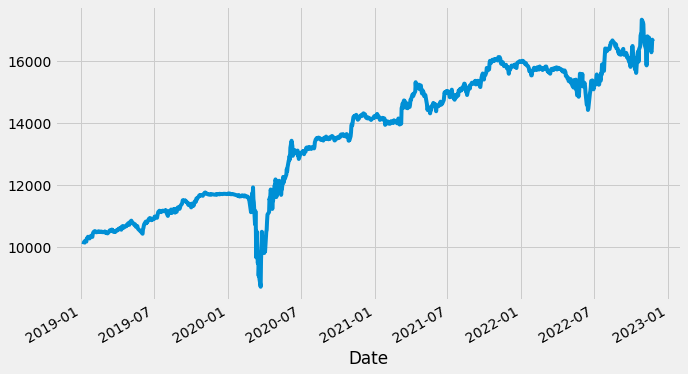

In [20]:
plt.style.use('fivethirtyeight')
portf_val['Total Pos'].plot(figsize=(10,6))

<AxesSubplot:xlabel='Date'>

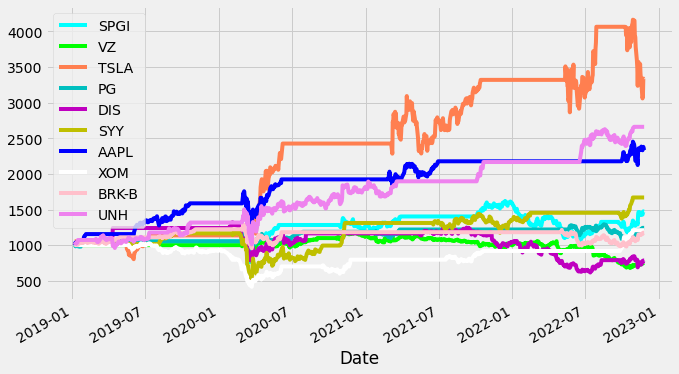

In [21]:
portf_val.drop('Total Pos', axis=1).plot(figsize=(10,6), color=['cyan', 'lime', 'coral', 'c', 'm', 'y', 'b', 'w','pink','violet'])

In [22]:
# Let’s see how much was our cumulative return.
cumulative_return = 100 * ( portf_val [ 'Total Pos' ] [-1] / portf_val ['Total Pos'] [2] -1)
print('Your cumulative return was {:.2f}%'.format(cumulative_return))
# We can check the portf_val last row to see how much our portfolio was worth.
portf_val.tail(1)

Your cumulative return was 63.88%


,SPGI,VZ,TSLA,PG,DIS,SYY,AAPL,XOM,BRK-B,UNH,Total Pos
Date,,,,,,,,,,,
2022-11-25,1472.297396,748.629784,3332.736906,1242.097339,784.097146,1668.940219,2333.152312,1209.576646,1174.404052,2660.974833,16626.906632


In [23]:
# add the percentage change in each day Pandas dataframe.pct_change()函数计算当前和之前元素之间的百分比变化
portf_val['Daily Return'] = portf_val['Total Pos'].pct_change(1)

In [24]:
# Formula: (expected portfolio return - risk-free investment rate)/ portfolio’s standard deviation. 
Sharpe_Ratio = portf_val['Daily Return'].mean() / portf_val['Daily Return'].std()
Sharpe_Ratio

0.051008159419725085

In [25]:
# annualize the Sharpe ratio,252 trading days in the year
# multiply the Sharpe ratio by the square root of 252
A_Sharpe_Ratio = (252 ** 0.5)*Sharpe_Ratio
A_Sharpe_Ratio

0.8097294279583758

## P/L

In [26]:
rsi_strategy_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
rsi_investment_ret_df = [df1,df2,df3,df4,df5,df6,df7,df8,df9,df10]
total_investment_ret = [0]*10

In [27]:
strategy[0]

,Close,rsi_14,rsi_signal,rsi_position,returns,log_returns,strat_returns,strat_log_returns,cum_returns,strat_cum_returns,Allocation,Position
Date,,,,,,,,,,,,
2019-01-07,173.639999,64.820788,0,1,1.008011,0.007979,1.008011,0.007979,1.008011,1.008011,0.100801,1008.011175
2019-01-08,175.229996,68.798475,0,1,1.009157,0.009115,1.009157,0.009115,1.017241,1.017241,0.101724,1017.241387
2019-01-09,173.660004,61.414329,0,1,0.991040,-0.009000,0.991040,-0.009000,1.008127,1.008127,0.100813,1008.127303
2019-01-10,177.149994,69.301916,0,1,1.020097,0.019897,1.020097,0.019897,1.028387,1.028387,0.102839,1028.387319
2019-01-11,175.979996,64.538867,0,1,0.993395,-0.006626,0.993395,-0.006626,1.021595,1.021595,0.102160,1021.595271
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-18,345.869995,60.355248,0,1,0.997405,-0.002599,0.997405,-0.002599,2.007837,1.422770,0.142277,1422.769657
2022-11-21,347.420013,61.090164,0,1,1.004482,0.004471,1.004482,0.004471,2.016835,1.429146,0.142915,1429.145807
2022-11-22,352.250000,63.368907,0,1,1.013902,0.013807,1.013902,0.013807,2.044874,1.449014,0.144901,1449.014423


In [28]:
# total investment_value $1 million
# calculate return 
for j in range(10):
    df_ret = pd.DataFrame(np.diff(strategy[j]['Close'])).rename(columns = {0:'returns'})
    rsi_strategy_ret = []
    
    for i in range(len(df_ret)):
        returns = df_ret['returns'][i]*(strategy[j]['rsi_position'][i])
        rsi_strategy_ret.append(returns)
    
    rsi_strategy_ret_df[j] = pd.DataFrame(rsi_strategy_ret).rename(columns = {0:'rsi_returns'})

    # calculate investement return 
    investment_value = 100000
    number_of_stocks = floor(investment_value/(strategy[j]['Close'][0]))
    rsi_investment_ret = []
    
    for i in range(len(rsi_strategy_ret_df[j]['rsi_returns'])):
        returns = number_of_stocks*rsi_strategy_ret_df[j]['rsi_returns'][i]
        rsi_investment_ret.append(returns)
    
    rsi_investment_ret_df[j] = pd.DataFrame(rsi_investment_ret).rename(columns = {0:'investment_returns'})
    total_investment_ret[j] = round(sum(rsi_investment_ret_df[j]['investment_returns']), 2)

In [29]:
total_investment_ret

[63037.24,
 -22584.03,
 549050.54,
 28134.06,
 -36657.19,
 59040.82,
 169113.23,
 24562.85,
 15666.3,
 140208.64]

In [30]:
for i in range(10):
    investment_value = 100000
    profit_percentage = floor((total_investment_ret[i]/investment_value)*100)
    print(cl('Profit gained from the RSI strategy by investing $100k in {} : {}'.format(name[i],total_investment_ret[i]), attrs = ['bold']))
    print(cl('Profit percentage of the RSI strategy: {}%'.format(profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing $100k in SPGI : 63037.24
Profit percentage of the RSI strategy: 63%
Profit gained from the RSI strategy by investing $100k in VZ : -22584.03
Profit percentage of the RSI strategy: -23%
Profit gained from the RSI strategy by investing $100k in TSLA : 549050.54
Profit percentage of the RSI strategy: 549%
Profit gained from the RSI strategy by investing $100k in PG : 28134.06
Profit percentage of the RSI strategy: 28%
Profit gained from the RSI strategy by investing $100k in DIS : -36657.19
Profit percentage of the RSI strategy: -37%
Profit gained from the RSI strategy by investing $100k in SYY : 59040.82
Profit percentage of the RSI strategy: 59%
Profit gained from the RSI strategy by investing $100k in AAPL : 169113.23
Profit percentage of the RSI strategy: 169%
Profit gained from the RSI strategy by investing $100k in XOM : 24562.85
Profit percentage of the RSI strategy: 24%
Profit gained from the RSI strategy by investing $100k in BRK-B

In [31]:
all_investment_value = 1000000
all_investment_ret = round(sum(total_investment_ret), 2)
all_profit_percentage = floor((all_investment_ret/all_investment_value)*100)
print(cl('Profit gained from the RSI strategy by investing 1 million in portfolio : {}'.format(all_investment_ret), attrs = ['bold']))
print(cl('Profit percentage of the RSI strategy: {}%'.format(all_profit_percentage), attrs = ['bold']))

Profit gained from the RSI strategy by investing 1 million in portfolio : 989572.46
Profit percentage of the RSI strategy: 98%
